# Import

Erstmal werde alle Funktionen importiert

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.cluster import KMeans

# Tinder für Streber

Tinder für Streber ist eine Plattform, die es Studenten ermöglicht einen Lernpartner zu finden. Hierfür suchen sie nach bestimmten Modulen, anhand derer sie gematcht werden. Wir haben uns hierbei auf das Jurastudium an drei Universitäten fokussiert (Heidelberg, Münster und Bayreuth). 

## Importieren der Daten

#### Das sind die Daten der Unis:

Wir haben anhand der Semesterpläne der Unis Münster, Heidelberg und Bayreuth die unterrichteten Module in einer Excel Tabelle (https://docs.google.com/spreadsheets/d/10gKSfIswyX1gq1vjlNtGStApSSlrRnuwQNZox-6nhz4/edit?usp=sharing) zusammengetragen und mit einer Modul ID versehen. Diese Modul ID wurde benötigt, da die Module an den verschiedenen Unis teilweise unterschiedlich benannt werden. 

In [2]:
file_path = 'DatenStudymatch.csv'

In [3]:
df = pd.read_csv(file_path)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   semester  114 non-null    int64  
 1   modul     114 non-null    object 
 2   modul_id  106 non-null    float64
 3   Credits   0 non-null      float64
 4   SWS       84 non-null     object 
 5   Uni       114 non-null    object 
 6   uni_id    114 non-null    int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 6.4+ KB


In [5]:
df.head()

,semester,modul,modul_id,Credits,SWS,Uni,uni_id
0,1,bgb_at,1.0,NaN,4,Bayreuth,3
1,1,Staatsorganisationsrecht,101.0,NaN,4,Bayreuth,3
2,1,strafrecht_1,201.0,NaN,4,Bayreuth,3
3,1,Bausteine des Rechts,301.0,NaN,2,Bayreuth,3
4,1,BWL Einführung,302.0,NaN,2,Bayreuth,3


#### Das sind die Daten für die Studenten:

Dann haben wir noch einen weiteren Datensatz mit 12 fiktiven Studenten erstellt.

In [6]:
file_path2 = 'Studenten.csv'

In [7]:
df2 = pd.read_csv(file_path2)

In [8]:
df2.head()

,Name,Semester,Uni,Auswahl
0,Lisa Müller,4,Bayreuth,Handelsrecht
1,Lisa Müller,4,Bayreuth,Gesellschaftsrecht I
2,Lisa Müller,4,Bayreuth,Besonderes Verwaltungsrecht
3,Lisa Müller,4,Bayreuth,Strafprozessrecht
4,Lukas Justus,5,Bayreuth,Erbrecht


## Bereinigen der Daten

#### Daten der Unis:

Wir haben uns überlegt, dass man die Credits, SWS und die Uni Id erstmal gar nicht braucht. Die Uni ID ist generell nicht unbedingt nötig und die Semesterwochenstunden und Credits wären weitere Faktoren, die man beim Matching später mit in Betracht ziehen kann. Wir haben beschlossen uns aber erstmal nur auf die Module zu konzentireren.

In [9]:
data = df.drop(['Credits','SWS','uni_id'], axis=1)

Wir haben gesehen, dass es nicht sehr viele fehlende Werte gibt und die Zeilen einfach gelöscht.

In [10]:
data = data.dropna()

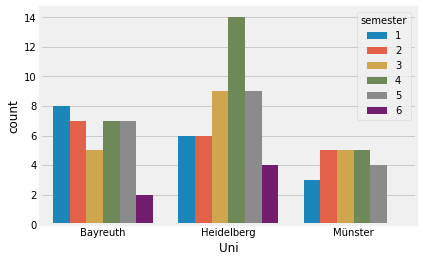

In [11]:
ax = sns.countplot(x="Uni", hue="semester", data=data)

In der obigen Abbildung kann man sehen, dass nicht in allen Semestern gleich viele Module unterrichtet werden. Wir erwarten, dass beispielsweise in Heidelberg die Studenten im Vierten Semester am meisten Module suchen und im Sechsten Semester am wenigsten. An unseren Daten kann man das aber nicht erkennen, da wir diese selbst erstellt haben.

Da bei den Studenten Daten Semester groß geschrieben wird, musste das bei den Uni Daten auch so sein, was wir hier erstmal verändert haben.

In [12]:
data.rename(columns={'semester':'Semester'}, inplace=True)

Im Nachhinein haben wir dann festgestellt, dass wir das Zusammenfügern der Daten nicht über das Semester machen wollen, da man ja auch etwas ein Semester später haben kann. Wir löschen also das Semester aus den Unidaten, da uns nur interessiert, in welchem Semester der Student gerade ist.

In [13]:
df = data.drop('Semester', axis=1)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 0 to 112
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Semester  106 non-null    int64  
 1   modul     106 non-null    object 
 2   modul_id  106 non-null    float64
 3   Uni       106 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 4.1+ KB


#### Daten der Studenten:

Bei den Daten der Studenten war das Einzige, was noch gemacht werden musste das Umbennenen von 'Auswahl' zu 'modul', sodass es zu den Daten der Unis passt, da wir die Datensätze später zusammenfügen wollen.

In [15]:
df2.rename(columns={'Auswahl':'modul'}, inplace=True)

## Erste Versuche der Datenverarbeitung

Als ersten Schritt, um uns mit dem Aufbau der Daten und möglichen Schritten der Verarbeitung vertraut zu machen haben wir uns erstmal nur die Unidaten angesehen und nach Überschneidungen gesucht.

Hier haben wir uns erst überlegt die Daten in drei Dataframes, für jede Uni einen, aufzuteilen. Wri haben aber festgestellt, dass das gar nicht nötig ist.

In [16]:
#for uni in data['Uni']:
#    data['Uni'] == 'Bayreuth'
    

Wir haben uns folgende Schritte überlegt, um erstmal für ein konkretes Modul herauszufinden, an welcher Uni das in welchem Semester angeboten wird:
- Modul eingeben
- Modul wird ID zugeordnet 
- ID wird in den Daten gesucht 
- DataFrame wird gefiltert - Unis + Semester etc werden andezeigt (mit gleicher Modul_Id) 


Hier haben wir erstmal die Daten nach dem Modul 'strafrecht_1' gefiltert und dessen Modul ID herausgefunden (2). Hier haben wir aber zunächst einen Dataframe als Output, obwohl wir eigentlich die Zahl wollen.

In [17]:
modul = data[data['modul']=='strafrecht_1']
modul.head()

,Semester,modul,modul_id,Uni
2,1,strafrecht_1,201.0,Bayreuth


Wir haben dann überlegt, ob man das durch eie Schleife lösen könnte:

In [18]:
for modul_id in modul['modul_id']: 
    data[data['modul_id']==modul_id]
    print(data)

     Semester                       modul  modul_id       Uni
0           1                      bgb_at       1.0  Bayreuth
1           1    Staatsorganisationsrecht     101.0  Bayreuth
2           1                strafrecht_1     201.0  Bayreuth
3           1        Bausteine des Rechts     301.0  Bayreuth
4           1              BWL Einführung     302.0  Bayreuth
..        ...                         ...       ...       ...
108         4          Gesellschaftsrecht       7.0   Münster
109         5                       ZPO_2      15.0   Münster
110         5                Handelsrecht       6.0   Münster
111         5           Grundzüge_des_IPR      17.0   Münster
112         5  Grundzüge_des_Arbeitsrecht       8.0   Münster

[106 rows x 4 columns]


Die Modul ID, die wir durch diese Schleife herausgefunden haben, haben wir nun in dem Dataframe der Unis gesucht und haben als Output in welchem Semester das Modul an welcher Uni unterrichtet wird.

In [19]:
data[data['modul_id']==modul_id]

,Semester,modul,modul_id,Uni
2,1,strafrecht_1,201.0,Bayreuth
38,1,Grundkurs Strafrecht I,201.0,Heidelberg
86,1,Strafrecht 1,201.0,Münster


### Überlegungen 08.03

Folgende Überlegungen haben wir uns dann zum weiteren Vorgehen gemacht:

- Daten zusammenfügen mit .join, wie in Tabellenblatt8 (in unserer Excel Datei) zu sehen
- Das wird dann eine sehr große Tabelle mit den Personen, bei denen anhand der Uni und dem Semester Zeilen hinzugefügt werden
- Dann muss man die Daten so umwandeln, dass da nur noch die bereits gemachten Module stehen (Da das Matching über das Semester läuft, müssen wir uns noch überlegen, wie wir die vorherigen Semester auch hinzufügen - sowas wie 1 bis x(=mein Semester)
- In der Tabelle sind dann alle Module (bzw. die IDs), die die Person bis dahin schon gemacht hat drin.
- Durch die Anzahl der Module ist dann auch klar welches Semester und welche Uni gemeint ist, da die Module davon abhängig sind, wir müssen also das beim Matchen nicht beachten.
-  
- Dann wendet man eine Methode darauf an, bei der man quasi eine bestimmte Person (nicht in dem Datensatz) mit den bestehenden Personen matcht, indem geguckt wird wieviele Module sich überschneiden.
-  
- Wir matchen jetzt welche Person insgesamt am besten passt, also zum generell gemeinsam lernen und nicht nach einem bestimmten Fach!

Diese Überlegungen haben wir im Nachhinein noch einmal revidiert, wie man im weiteren Verlauf sehen kann.

## Daten zusammenfügen

Wir haben uns überlegt, mit .join die Dataframes zusammenzufügen und dann so umzuformen, dass für jeden Studenten alle gesuchten Module zu sehen sind. Wir haben uns ja vorher überlegt, die Dataframes zusammenzufügen auf Grundlage der Uni und des Semesters, in dem sich die Student:innen gerade befinden. Wir haben unseren Datensatz für die Studenten aber so ergänzt, dass nach bis zu vier Modulen gesucht wird und dort die größte Überschneidung gesucht wird. <br>
Wir fügen also jetzt auf Grundlage der Uni und des gesuchten Moduls zusammen.

In [20]:
data_joined = df2.join(df.set_index(['Uni','modul']), on=['Uni','modul'])

In [21]:
data_joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      25 non-null     object 
 1   Semester  25 non-null     int64  
 2   Uni       25 non-null     object 
 3   modul     25 non-null     object 
 4   modul_id  24 non-null     float64
dtypes: float64(1), int64(1), object(3)
memory usage: 1.1+ KB


In [22]:
data_joined.head()

,Name,Semester,Uni,modul,modul_id
0,Lisa Müller,4,Bayreuth,Handelsrecht,6.0
1,Lisa Müller,4,Bayreuth,Gesellschaftsrecht I,7.0
2,Lisa Müller,4,Bayreuth,Besonderes Verwaltungsrecht,105.0
3,Lisa Müller,4,Bayreuth,Strafprozessrecht,204.0
4,Lukas Justus,5,Bayreuth,Erbrecht,11.0


In [23]:
data_joined.isna().sum()

Name        0
Semester    0
Uni         0
modul       0
modul_id    1
dtype: int64

Nachdem wir wie oben gesehen uns den neuen Dataframe ein wenig angesehen haben, haben wir beschlossen das eine Modul für den einen Studenten einfach zu löschen, da das für das was wir zeigen wollen nicht so sehr relevant ist.

In [24]:
data_joined = data_joined.dropna()

In [25]:
data_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 0 to 24
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      24 non-null     object 
 1   Semester  24 non-null     int64  
 2   Uni       24 non-null     object 
 3   modul     24 non-null     object 
 4   modul_id  24 non-null     float64
dtypes: float64(1), int64(1), object(3)
memory usage: 1.1+ KB


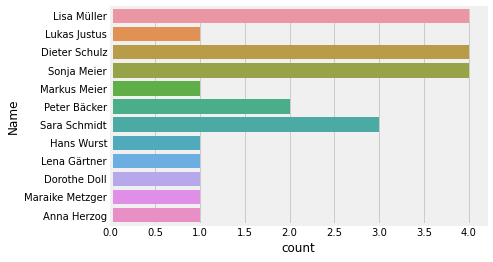

In [26]:
ax = sns.countplot(y="Name", data=data_joined)

In der obigen Abbildung kann man sehen in wievielen Fächern die einzelnen Studenten Hilfe benötigen. Man sieht, dass die meisten Studenten nur nach einem Modul suchen.

In [27]:
data_joined.groupby('Name').rank().mean()

Semester    1.916667
modul_id    1.916667
dtype: float64

Im Durchschnitt suchen die Studenten circa 1,9 Module.

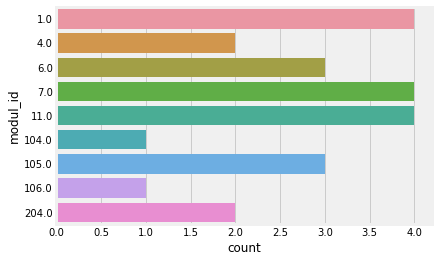

In [28]:
ax = sns.countplot(y="modul_id", data=data_joined)

Die meistgesuchten Module sind BGB (modul_id = 1), Gesellschaftsrecht (modul_id = 7), Erbrecht (modul_id = 11). Man kann davon ausgehen, dass das die Module sind, bei denen die meisten Probleme auftreten. Bei uns sind das natürlich nur fiktive Daten.

## Daten modellieren

Als nächstes haben wir uns überlegt die Daten so zu modellieren, dass wir die Studenten mit dem kmeans Algorithmus in verschiene Cluster, also Gruppen einordnen können. Innerhalb dieser Gruppe finden sich dann die potentiellen Lernpartner. Dieses Matching soll dann rein auf den gesuchten Modul IDs beruhen. Deashalb haben wir die Daten erstmal auf den Namen und die Modul ID begrenzt.

In [29]:
df_new = data_joined[['Name','modul_id']]

Da wir mehrere Module pro Name haben, brauchten wir einen Rang, welcher die Spalten des modellierten Dataframes darstellen sollte und damit dann für jeden Namen alle vorhandenen Module anzeigt.

In [30]:
df_new['rank'] = df_new.groupby('Name').rank()

Danach haben wir mit .pivot den DataFrame modelliert:

In [31]:
df_pivot = df_new.pivot(index='Name',columns='rank',values='modul_id')

In [32]:
df_pivot

rank,1.0,2.0,3.0,4.0
Name,,,,
Anna Herzog,1.0,NaN,NaN,NaN
Dieter Schulz,4.0,6.0,105.0,204.0
Dorothe Doll,1.0,NaN,NaN,NaN
Hans Wurst,1.0,NaN,NaN,NaN
Lena Gärtner,6.0,NaN,NaN,NaN
Lisa Müller,6.0,7.0,105.0,204.0
Lukas Justus,11.0,NaN,NaN,NaN
Maraike Metzger,1.0,NaN,NaN,NaN
Markus Meier,4.0,NaN,NaN,NaN


Da kmeans nicht mit NaN Werten arbeiten kann, haben wir uns überlegt, welche Werte wir dafür einsetzen können. Da man auf jeden Fall die Unterscheidung zuwischen mehrere Module ausgewählt und nur eins ausgewählt, haben wir uns erst überlegt, dass man besonders hohe Werte nehmen könnte.

In [33]:
df_pivot = df_pivot.fillna(-20)

## Matching

Als nächstes haben wir damit begonnen die Daten mit kmeans zu clustern, um die Ähnlichkeiten herauszufinden. Hier haben wir ein bisschen mit der Anzahl der Cluster variiert, um zu beurteilen, welche Anzahl das beste Matching bewirkt. Die Variable random_state musste gesetzt werden, um dem Algorithmus sozusagen einen Ausgangspunkt zu geben. Wir haben hier eine beliebige Zahl genommen.

In [34]:
kmeans = KMeans(n_clusters=5, random_state=42)

In [35]:
df_pivot['cluster'] = kmeans.fit_predict(df_pivot)

In [36]:
df_pivot['cluster']

Name
Anna Herzog        1
Dieter Schulz      2
Dorothe Doll       1
Hans Wurst         1
Lena Gärtner       1
Lisa Müller        2
Lukas Justus       1
Maraike Metzger    1
Markus Meier       1
Peter Bäcker       4
Sara Schmidt       3
Sonja Meier        0
Name: cluster, dtype: int32

In [37]:
centroids = kmeans.cluster_centers_

Das Ergebnis war leider nicht sehr zufriedenstellend: <br>
Die letzten 3 Personen wurden fast immer in ein eigenes Cluster, wo nur der eine Wert drin war eingeordnet. Was man daran erkennen kann, ist dass Peter Bäcker der Einzige mit zwei gewählten Modulen und Sara Schmidt die Einzige mit 3 ausgewählten Modulen ist. <br>
Sonja Meier ist zwar nicht die Einzige mit 4 Modulen, aber zwischen den Modul IDs der anderen Studenten mit 4 Modulen besteht ein großer Unterschied. <br>
Außerdem sind  alle Studenten, die nur ein Modul suchen in einem Cluster.

Der Algorithmus ist also alleine noch nicht in der Lage ein vernünftiges Matching zu erstellen, man erkennt aber, dass zumindest erkannt wird, wieviele Module gesucht werden. Vielleicht würde es bei einem größeren Datensatz besser funktionieren und eventuell ist es nötig die einzelnen Cluster noch weiter zu filtern. Bei einem größeren Datesatz kann man dann auch noch die Credits und Semesterwochenstunden hierfür verwenden.

## Visualisierung und Reflektion

Trotz des Ergebnisses haben wir die Cluster hier noch einmal visualisiert:

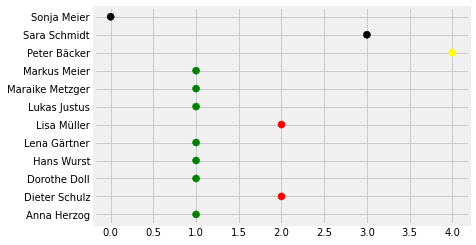

In [38]:
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]
## add to df
df_pivot['cen_x'] = df_pivot.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
df_pivot['cen_y'] = df_pivot.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})
# define and map colors
colors = ['black', 'green', 'red', 'black', 'yellow', 'pink']
df_pivot['c'] = df_pivot.cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3], 4:colors[4], 5:colors[5]})
plt.scatter(df_pivot.cluster, df_pivot.index, c=df_pivot.c, alpha = 1, s=50)

Man kann auch hier wieder gut sehen, dass die meisten Studenten in Cluster 1 sortiert wurden, da sie alle nur ein Modul gesucht haben. Diese Studenten könnte man, beim Weiterentwickeln des Matching Prozesses auch noch Matchen, um so ein besseres Ergebnis zu erhalten.

Generell müssen wir uns aber fragen, ob kmeans der richtige Algorithmus ist, um unsere Studenten zu matchen oder ob man nicht noch andere Möglichkeiten in Betracht ziehen muss. Wir sind zu dem Schluss gekommen, dass zumindest bei großen Datenmengen kmeans gut zu einer ersten Einsortierung geeignet ist, man aber danach noch weiter Filtern muss, um auch wirklich Paare zu finden. <br>
Eventuell muss man auch bei der Vergabe der Modul ID auch noch mehr Faktoren mit einbeziehen. Hierbei denken wir daran ähnliche Themenbereiche mit IDs zu versehen, die sich auch von den Zahlen her ähneln, damit der ALgorithmus auch die Ähnlichkeit erkennt.